<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw3/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement a GAN model and run it on a dataset. We provide the expected outputs to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code.

In [ ]:
# !if [ -d deepul ]; then rm -Rf deepul; fi
# !git clone https://github.com/rll/deepul.git 
# !pip install ./deepul

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from deepul.hw3_helper import *
import deepul.pytorch_util as ptu
import warnings
warnings.filterwarnings('ignore')

ptu.set_gpu_mode(True)

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
from scipy.stats import norm
from tqdm import trange, tqdm_notebook, tqdm
from collections import OrderedDict

/data/anaconda3/envs/deepul_bear/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Question 1: Warmup [20pt]

In this question, we will train different variants of GANs on an easy 1D dataset. 

Execute the cell below to visualize our datasets.

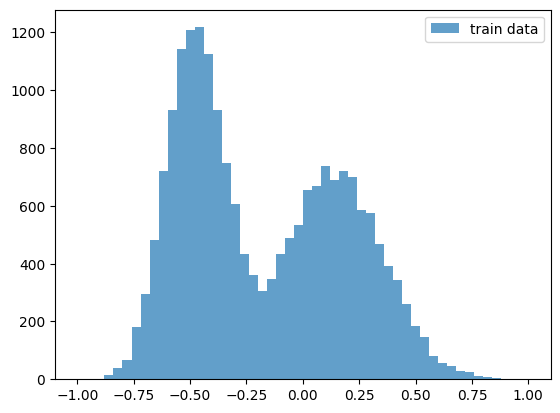

In [3]:
visualize_q1_dataset()

## Part 1(a)
In this part, we'll train our generator and discriminator via the original minimax GAN objective:
<insert GAN Objective here>
$$min_{G} max_{D} \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$

Use an MLP for both your generator and your discriminator, and train until the generated distribution resembles the target distribution. 
* 3 layers
* 128 hidden dim
* LeakyReLU nonlinearities with negative_slope=0.2

### Solution

In [3]:
class MLP(nn.Module):
    def __init__(self, input_shape, output_shape, hiddens=[]):
        super().__init__()

        if isinstance(input_shape, int):
            input_shape = (input_shape,)
        if isinstance(output_shape, int):
            output_shape = (output_shape,)

        self.input_shape = input_shape
        self.output_shape = output_shape
        self.hiddens = hiddens

        model = []
        prev_h = np.prod(input_shape)
        for h in hiddens + [np.prod(output_shape)]:
            model.append(nn.Linear(prev_h, h))
            model.append(nn.LeakyReLU(0.2))
            prev_h = h
        model.pop()
        self.net = nn.Sequential(*model)

    def forward(self, x):
        b = x.shape[0]
        x = x.view(b, -1)
        return self.net(x).view(b, *self.output_shape)


class MlpCritic(MLP):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def loss(self, x_real, x_fake):
        """
        Critic loss over a minibatch

        Args:
            x (torch.tensor): [B, 1], samples from data
            z (torch.tensor): [B, 1], samples from noise prior
            generator (nn.Module): The generator model that takes in samples
                from noise prior and produce samples
        Returns:
            loss (torch.tensor): [1,] mean critic loss over minibatch 
                Suppose critic logits is y for data and yhat for samples
                loss = -(log(sigmoid(y)) + log(1 - sigmoid(yhat)))
                = log(1 + exp(-y)) + yhat + log(1 + exp(-yhat))
        """
        d_x_real = self(x_real)
        d_x_fake = self(x_fake)
        x_real_loss = F.binary_cross_entropy_with_logits(d_x_real, torch.full_like(d_x_real, 1).cuda())
        x_fake_loss = F.binary_cross_entropy_with_logits(d_x_fake, torch.full_like(d_x_fake, 0).cuda())
        loss = x_real_loss + x_fake_loss
        # loss = torch.log1p(torch.exp(-y_data)) + y_samples + torch.log1p(torch.exp(-y_samples))
        return loss


class MlpGenerator(MLP):
    def __init__(self, prior_sampler, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.prior_sampler = prior_sampler

    def forward(self, x_real):
        """
        Args:
            x_real: samples from data, only used to indicate how many
                fake samples to generate
                written in this way so vqgan can be directly used as a generator
        """
        n_samples = x_real.shape[0]
        z = self.prior_sampler(n_samples).cuda()
        x_fake = super().forward(z)
        return OrderedDict(x_fake=x_fake)
    
    def loss(self, x_real, critic):
        """
        Generator loss over a minibatch

        Returns:
            loss (torch.tensor): [1,], mean generator loss over minibatch
            loss = log(1 - sigmoid(yhat))
        """
        x_fake = self(x_real)['x_fake']
        d_x_fake = critic(x_fake)
        loss = - F.binary_cross_entropy_with_logits(d_x_fake, torch.full_like(d_x_fake, 0).cuda())
        # loss = - y_samples - torch.log1p(torch.exp(-y_samples))
        return OrderedDict(loss=loss)

In [4]:
def train_gan(
        critic, generator, train_loader,
        optimizer_D, scheduler_D, optimizer_G, scheduler_G,
        epoch, n_critic=1, grad_clip=None):
    """
    Train critic / generator alternatively over the dataset
    """
    critic.train()
    generator.train()
    critic_losses = []
    generator_losses = OrderedDict()

    for i, x in enumerate(train_loader):
        x_real = x.cuda().contiguous()
        x_fake = generator(x_real)['x_fake']
        
        # train critic for every minibatch
        critic_loss = critic.loss(x_real, x_fake)
        optimizer_D.zero_grad()
        critic_loss.backward()
        if grad_clip:
            torch.nn.utils.clip_grad_norm_(critic.parameters(), grad_clip)
        optimizer_D.step()
        scheduler_D.step()
        critic_losses.append(critic_loss.item())

        # train generator every n_critic minibatches
        if i % n_critic == 0:
            # sample a different fake from prior
            out = generator.loss(x_real, critic)
            optimizer_G.zero_grad()
            out['loss'].backward()
            if grad_clip:
                torch.nn.utils.clip_grad_norm_(generator.parameters(), grad_clip)
            optimizer_G.step()
            scheduler_G.step()
            # add each loss term for minibatch (for vqgan)
            for k, v in out.items():
                if k not in generator_losses:
                    generator_losses[k] = []
                generator_losses[k].append(v.item())

    return critic_losses, generator_losses


def sample_from_generator(generator, n_samples):
    """
    Sample from generator by sampling from prior

    Returns:
        samples (np.ndarray): [B, out_dim]
    """
    generator.eval()
    with torch.no_grad():
        x_real = torch.full((n_samples,), 0)
        samples = generator(x_real)['x_fake']
    return samples.detach().cpu().numpy()


def eval_model(critic, eval_pts):
    """
    Evaluate critic outputs (after sigmoid at each eval_pts)

    Args:
        eval_pts (torch.tensor): [B, in_dim]
    Returns:
        (np.ndarray): [B,]
    """
    critic.eval()
    with torch.no_grad():
        logits = critic(eval_pts)
    return F.sigmoid(logits).detach().cpu().numpy().flatten()


def eval_generator_losses(generator, critic, val_loader):
    generator.eval()
    total_losses = OrderedDict()
    with torch.no_grad():
        for x in val_loader:
            x = x.cuda()
            out = generator.loss(x, critic)
            for k, v in out.items():
                total_losses[k] = total_losses.get(k, 0) + v.item() * x.shape[0]
        # average over the dataset
        for k in total_losses.keys():
            total_losses[k] /= len(val_loader.dataset)
    return total_losses


def get_lr(step, total_steps, warmup_steps, use_cos_decay, use_linear_anneal=False):
    if step < warmup_steps:
        # Linear warmup
        mul = (step + 1) / warmup_steps
        return mul
    elif use_linear_anneal:
        # Linear annealing to 0
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return max(1 - progress, 0)  # Ensures the learning rate doesn't go negative
    elif use_cos_decay:
        # Cosine decay
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return (1 + math.cos(math.pi * progress)) / 2
    else:
        return 1


def train_epochs(critic, generator, train_loader, train_args, quiet=True, val_loader=None):
    epochs, lr = train_args['epochs'], train_args['lr']
    n_critic = train_args.get('n_critic', 1)
    grad_clip = train_args.get('grad_clip', None)
    warmup_steps = train_args.get('warmup', 0)
    use_cos_decay = train_args.get('use_cos_decay', False)
    use_linear_anneal = train_args.get('use_linear_anneal', False)
    betas = train_args.get('adam_betas', (0.9, 0.999))
    
    optimizer_D = optim.Adam(critic.parameters(), lr=lr, betas=betas)
    optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=betas)
    scheduler_D = torch.optim.lr_scheduler.LambdaLR(
        optimizer_D, 
        lr_lambda=lambda step: get_lr(step, epochs * len(train_loader), warmup_steps, use_cos_decay, use_linear_anneal)
    )
    scheduler_G = torch.optim.lr_scheduler.LambdaLR(
        optimizer_G,
        lr_lambda=lambda step: get_lr(step, epochs * len(train_loader) // n_critic, warmup_steps, use_cos_decay, use_linear_anneal)
    )

    # validation loss before training
    val_losses = OrderedDict()
    if val_loader:
        val_loss = eval_generator_losses(generator, critic, val_loader)
        for k in val_loss.keys():
            val_losses[k] = [val_loss[k]]
        
    critic_losses, generator_losses = [], OrderedDict()
    for epoch in tqdm(range(epochs)):
        # train gan
        critic_loss, generator_loss = train_gan(
            critic, generator, train_loader,
            optimizer_D, scheduler_D, optimizer_G, scheduler_G, 
            epoch, n_critic, grad_clip
        )
        critic_losses.extend(critic_loss)
        for k in generator_loss.keys():
            if k not in generator_losses:
                generator_losses[k] = []
            generator_losses[k].extend(generator_loss[k])
        if not quiet:
            print(f'Epoch {epoch}, Critic loss {sum(critic_loss) / len(critic_loss):.4f}')

        # evaluate recon_loss on val_loader for vqgan per epoch
        if val_loader:
            val_loss = eval_generator_losses(generator, critic, val_loader)
            for k in val_loss.keys():
                val_losses[k].append(val_loss[k])
            
    return critic_losses, generator_losses, val_losses

In [82]:
def q1_a(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """
    train_loader = data.DataLoader(torch.tensor(train_data).to(dtype=torch.float32), batch_size=500, shuffle=True)
    z_dim = 1 # dimension of z
    prior_sampler = lambda n_samples: torch.randn((n_samples, z_dim)) # sample z ~ N(0, 1) 
    critic = MlpCritic(input_shape=1, output_shape=1, hiddens=[128, 128, 128]).cuda()
    generator = MlpGenerator(input_shape=z_dim, output_shape=1, hiddens=[128, 128, 128], prior_sampler=prior_sampler).cuda()
    train_args = dict(epochs=2000, lr=1e-3, n_critic=5)

    eval_pts = torch.linspace(-1, 1, 1000).unsqueeze(1).cuda() # [1000, 1]
    # evaluate before training
    samples_epoch1 = sample_from_generator(generator, 5000)
    critic_output_epoch1 = eval_model(critic, eval_pts)
    critic_losses, _, _ = train_epochs(
        critic, generator, train_loader, train_args)
    # evaluate after training
    samples_final = sample_from_generator(generator, 5000)
    critic_output_final = eval_model(critic, eval_pts)
    eval_pts = eval_pts.detach().cpu().numpy().flatten()

    return critic_losses, samples_epoch1, eval_pts, critic_output_epoch1, samples_final, eval_pts, critic_output_final

### Results

100%|██████████| 2000/2000 [06:37<00:00,  5.03it/s]


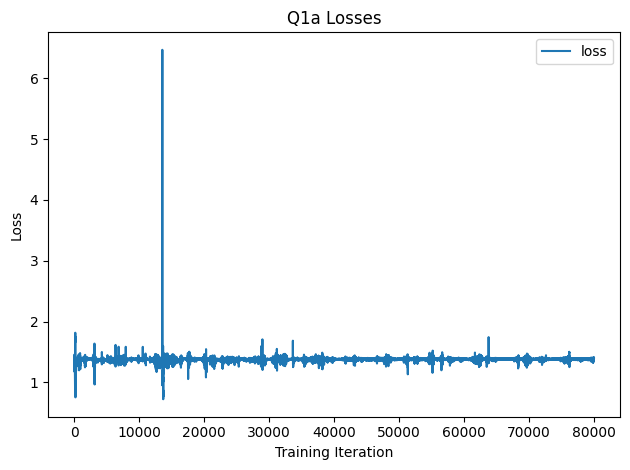

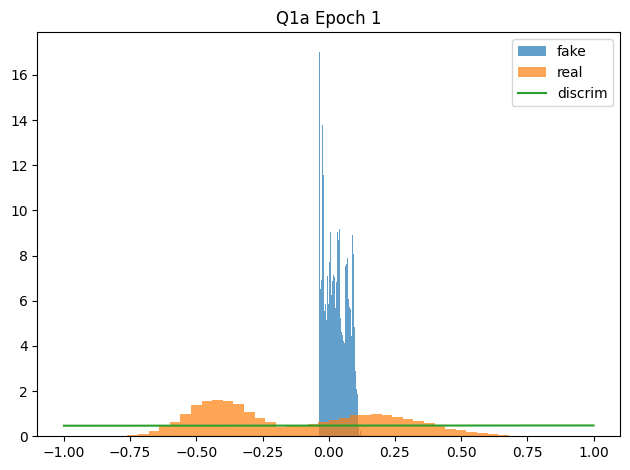

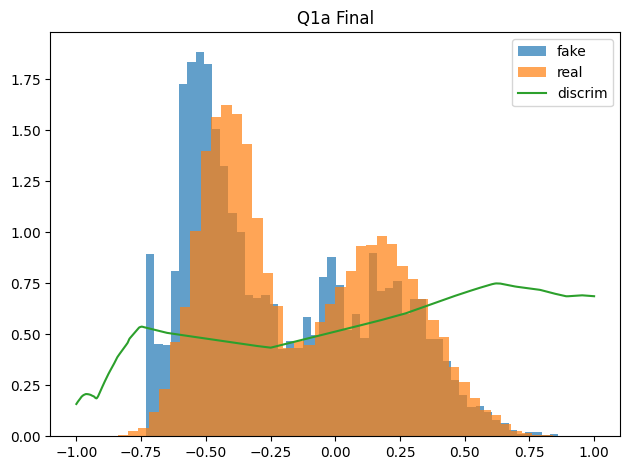

In [83]:
q1_save_results('a', q1_a)

## Part 1(b)
Here, we'll use the non-saturating formulation of the GAN objective. Now, we have two separate objectives:
$$L^{(D)} = \mathbb{E}_{x \sim p_{data}} [\log D(x)] + \mathbb{E}_{z \sim p(z)}[\log (1-D(G(z)))]$$
$$L^{(G)} = - \mathbb{E}_{z \sim p(z)} \log(D(G(z)))$$

 ### Solution

In [8]:
class MlpGeneratorNonSaturating(MlpGenerator):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def loss(self, x_real, critic):
        """
        Generator loss over a minibatch

        Returns:
            loss (torch.tensor): [B, 1], generator loss for every sample in minibatch
        """
        x_fake = self(x_real)['x_fake']
        d_x_fake = critic(x_fake)
        loss = F.binary_cross_entropy_with_logits(d_x_fake, torch.full_like(d_x_fake, 1).cuda())
        return OrderedDict(loss=loss)

In [79]:
def q1_b(train_data):
    """
    train_data: An (20000, 1) numpy array of floats in [-1, 1]

    Returns
    - a (# of training iterations,) numpy array of discriminator losses evaluated every minibatch
    - a numpy array of size (5000,) of samples drawn from your model at epoch #1
    - a numpy array of size (100,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (100,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at epoch #1

    - a numpy array of size (5000,) of samples drawn from your model at the end of training
    - a numpy array of size (1000,) linearly spaced from [-1, 1]; hint: np.linspace
    - a numpy array of size (1000,), corresponding to the discriminator output (after sigmoid) 
        at each location in the previous array at the end of training
    """

    train_loader = data.DataLoader(torch.tensor(train_data).to(dtype=torch.float32), batch_size=256, shuffle=True)
    z_dim = 1 # dimension of z
    prior_sampler = lambda n_samples: torch.randn((n_samples, z_dim)) # sample z ~ N(0, 1) 
    critic = MlpCritic(input_shape=1, output_shape=1, hiddens=[128, 128, 128]).cuda()
    generator = MlpGeneratorNonSaturating(input_shape=z_dim, output_shape=1, hiddens=[128, 128, 128], prior_sampler=prior_sampler).cuda()
    train_args = dict(epochs=500, lr=1e-3, n_critic=5)

    eval_pts = torch.linspace(-1, 1, 1000).unsqueeze(1).cuda() # [1000, 1]
    # evaluate before training
    samples_epoch1 = sample_from_generator(generator, 5000)
    critic_output_epoch1 = eval_model(critic, eval_pts)
    critic_losses, _, _ = train_epochs(
        critic, generator, train_loader, train_args)
    # evaluate after training
    samples_final = sample_from_generator(generator, 5000)
    critic_output_final = eval_model(critic, eval_pts)
    eval_pts = eval_pts.detach().cpu().numpy().flatten()

    return critic_losses, samples_epoch1, eval_pts, critic_output_epoch1, samples_final, eval_pts, critic_output_final

 ### Results

100%|██████████| 1000/1000 [01:41<00:00,  9.88it/s]


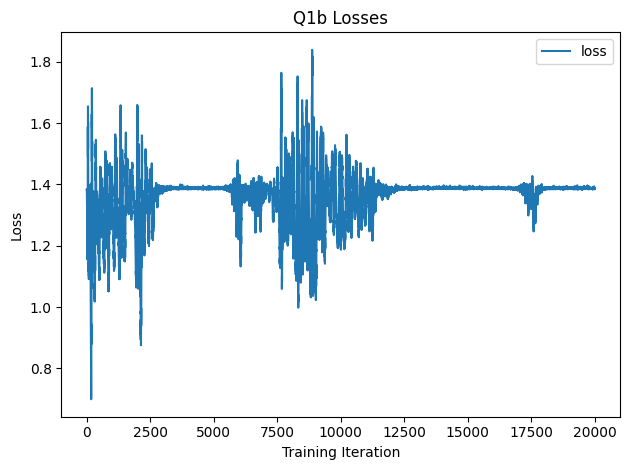

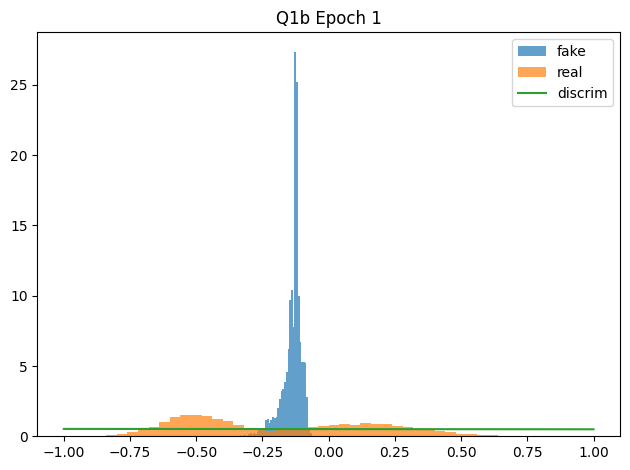

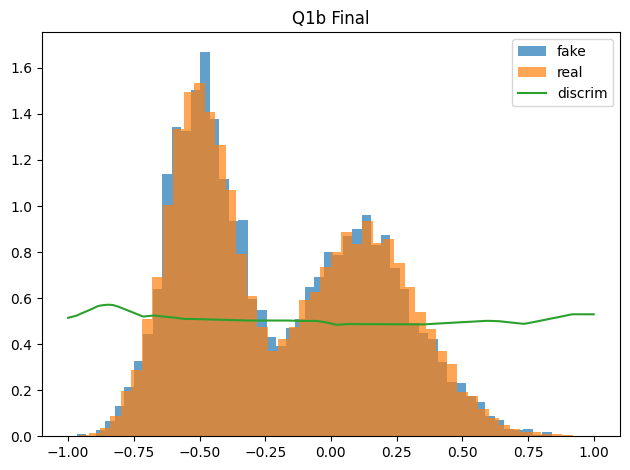

In [16]:
q1_save_results('b', q1_b)

# Question 2: GANs on CIFAR-10 [35pt]

In this exercise, you will train a GAN on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


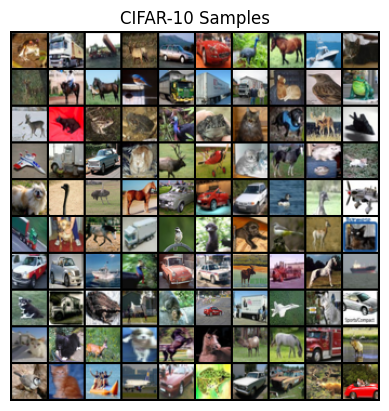

In [9]:
visualize_q2_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf) (see page 17), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
The discriminator (no BatchNorm!).
```
def Discriminator(*):
    def __init__(self, n_filters=128):
        ResnetBlockDown(3, n_filters=n_filters),
        ResnetBlockDown(128, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        ResBlock(n_filters, n_filters=n_filters),
        nn.ReLU()
        global sum pooling
        nn.Linear(128, 1)
```


**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Fréchet inception distance (bonus, 5pts)
3. Discriminator loss across training
4. 100 samples. 

## Solution

 ### Models

In [10]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width,
                                                                                      s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output


# Spatial Upsampling with Nearest Neighbors
class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.layers = nn.Sequential(
            DepthToSpace(block_size=2),
            nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
        )

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        return self.layers(x)


# Spatial Downsampling with Spatial Mean Pooling
class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.space_to_depth = SpaceToDepth(block_size=2)
        self.conv = nn.Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)
        
    def forward(self, x):
        x = self.space_to_depth(x)
        chunks = x.chunk(4, dim=1)
        # Stack the chunks along a new dimension (e.g., dim=0) 
        # and then compute the mean across this dimension
        x = torch.stack(chunks, dim=0).mean(dim=0)        
        x = self.conv(x)
        return x


class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.layers = nn.Sequential(
            nn.BatchNorm2d(in_dim),
            nn.ReLU(),
            nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
            nn.BatchNorm2d(n_filters),
            nn.ReLU()
        )
        self.residual_upsample = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.shortcut_upsample = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        _x = x
        _x = self.layers(_x)
        residual = self.residual_upsample(_x)
        shortcut = self.shortcut_upsample(x)
        return residual + shortcut


class ResnetBlockDown(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256, use_spectral_norm=False):
        super().__init__()
        self.layers = nn.Sequential(
            nn.ReLU(),
            nn.utils.spectral_norm(nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)) if use_spectral_norm else nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),            
            nn.ReLU()
        )
        self.residual_downsample = Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)
        self.shortcut_downsample = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        _x = x
        _x = self.layers(_x)
        residual = self.residual_downsample(_x)
        shortcut = self.shortcut_downsample(x)
        return residual + shortcut


class ResBlock(nn.Module):
    """
    Resnet block with no up or downsampling
    """
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256, use_spectral_norm=False):
        super().__init__()
        if use_spectral_norm:
            self.conv1 = nn.utils.spectral_norm(nn.Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=1))
        else:
            self.conv1 = nn.Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        if use_spectral_norm:
            self.conv2 = nn.utils.spectral_norm(nn.Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=1))
        else:
            self.conv2 = nn.Conv2d(in_dim, n_filters, kernel_size, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.shortcut = nn.Identity()  # Use identity if dimensions match

    def forward(self, x):
        shortcut = self.shortcut(x)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        return x + shortcut

In [11]:
class WGANGenerator(nn.Module):
    def __init__(self, prior_sampler, n_filters=128):
        super().__init__()
        self.prior_sampler = prior_sampler
        self.n_filters = n_filters
        # Assuming the output of the first Linear layer is reshaped to [batch_size, 256, 4, 4]
        self.linear = nn.Linear(128, 4*4*256)
        self.resnet_block1 = ResnetBlockUp(in_dim=256, n_filters=n_filters)
        self.resnet_block2 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
        self.resnet_block3 = ResnetBlockUp(in_dim=n_filters, n_filters=n_filters)
        self.batch_norm = nn.BatchNorm2d(n_filters)
        self.conv = nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x_real):
        n_samples = x_real.shape[0]
        # [batch_size, 128]
        z = self.prior_sampler(n_samples).cuda()
        x = self.linear(z)
        x = x.view(-1, 256, 4, 4)  # Reshape to [batch_size, 256, 4, 4]
        x = self.resnet_block1(x)
        x = self.resnet_block2(x)
        x = self.resnet_block3(x)
        x = self.batch_norm(x)
        x = self.relu(x)
        x = self.conv(x)
        x = self.tanh(x)
        return OrderedDict(x_fake=x)

    def loss(self, x_real, critic):
        x_fake = self(x_real)['x_fake']
        d_x_fake = critic(x_fake)
        loss = -d_x_fake.mean()
        return OrderedDict(loss=loss)

class WGANCritic(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.resnet_block_down1 = ResnetBlockDown(in_dim=3, n_filters=n_filters)
        self.resnet_block_down2 = ResnetBlockDown(in_dim=128, n_filters=n_filters)
        self.res_block1 = ResBlock(in_dim=n_filters, n_filters=n_filters)
        self.res_block2 = ResBlock(in_dim=n_filters, n_filters=n_filters)
        self.relu = nn.ReLU()
        # Assuming global sum pooling is done manually in the forward method
        self.linear = nn.Linear(n_filters, 1)

    def forward(self, x):
        x = self.resnet_block_down1(x)
        x = self.resnet_block_down2(x)
        x = self.res_block1(x)
        x = self.res_block2(x)
        x = self.relu(x)
        # Implementing global sum pooling as a sum followed by a reshape
        x = torch.sum(x, dim=[2, 3])  # Assuming x has shape [batch_size, n_filters, height, width]
        x = self.linear(x)
        return x

    def loss(self, x_real, x_fake, lambda_gp=10):
        """
        Args:
            x (torch.tensor): [B, 3, 32, 32], input image
            z (torch.tensor): [B, 128], noise from prior
        """
        # Compute critic loss
        d_x_fake = self(x_fake)
        d_x_real = self(x_real)
        critic_loss = d_x_fake.mean() - d_x_real.mean()

        # Interpolate between real and fake data
        # for each minibatch sample
        epsilon = torch.rand(x_real.size(0), 1, 1, 1).cuda()
        x_hat = epsilon * x_real + (1 - epsilon) * x_fake
        x_hat.requires_grad_(True)
        d_x_hat = self(x_hat)

        # Compute gradients of d_x_hat with respect to x_hat
        gradients = torch.autograd.grad(
            outputs=d_x_hat,
            inputs=x_hat,
            grad_outputs=torch.ones_like(d_x_hat),
            create_graph=True,
            retain_graph=True,
            only_inputs=True
        )[0]
        # Compute the norm of the gradients
        # take l2-norm over the feature dimensions
        gradient_norm = gradients.norm(2, dim=(1, 2, 3))
        # Average over minibatch
        gradient_penalty = lambda_gp * ((gradient_norm - 1)**2).mean()

        loss = critic_loss + gradient_penalty
        return loss

In [12]:
def q2(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    train_loader = data.DataLoader(torch.tensor(train_data).to(dtype=torch.float32), batch_size=256, shuffle=True)
    critic = WGANCritic().cuda()
    prior_sampler = lambda n_samples: torch.randn((n_samples, 128)) # sample z ~ N(0, 1) 
    generator = WGANGenerator(prior_sampler).cuda()
    train_args = dict(epochs=125, lr=2e-4, adam_betas=(0, 0.9), n_critic_steps=5, grad_clip=0.01)

    critic_losses, _, _ = train_epochs(
        critic, generator, train_loader, train_args)
    samples = sample_from_generator(generator, 1000) # [B, 3, 32, 32]
    samples = np.transpose(samples, (0, 2, 3, 1)) # [B, 32, 32, 3]

    return critic_losses, samples

## Results

Files already downloaded and verified


100%|██████████| 125/125 [49:04<00:00, 23.55s/it]

.

.........Inception score: 8.076201


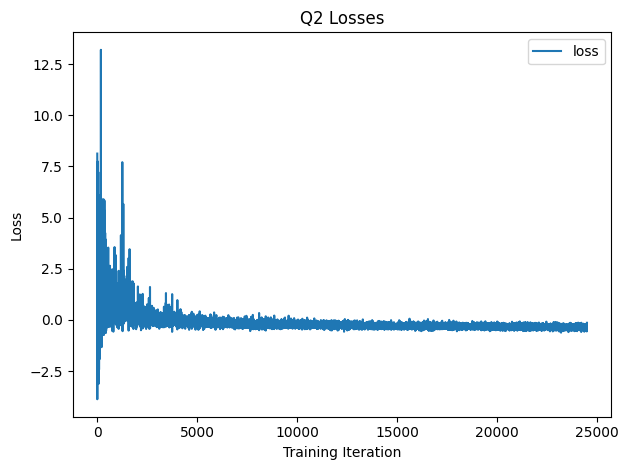

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


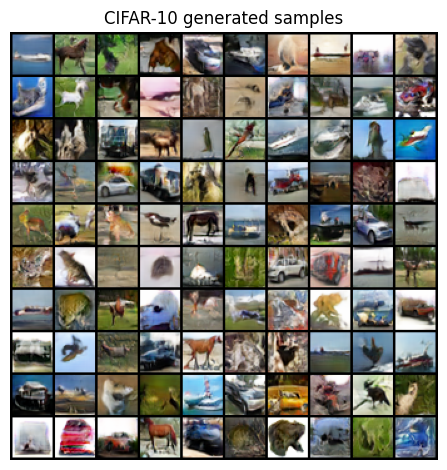

In [13]:
q2_save_results(q2)

# Question 3 : Quantization with GANS [40pt]
In this question, you'll train a variants of the VQGAN model to learn a mapping between image and a discrete codebook. We will do this on the CIFAR10 dataset.

## Part a: Vanilla VQGAN [25]
[VQGAN](https://github.com/CompVis/taming-transformers) extends the ideas from VQVAE by adding an additional GAN loss. Review HW 2 for more details on VQVAE, and may use your code from HW 2 (or HW2 solutions) to help with this question. Conceptually, the training procedure is the same as VQVAE, but with the addition of a discriminator network and its training.

Following the original VQGAN paper, we will use a patch-based discriminator. Split the image into 8x8 patches, which will be then fed into the discriminator. For the discrimiator you can use an architecture similar to the one used in the previous questions.
```
def Discriminator(*, n_filters=128):
    split to 8x8 patches
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.ReLU()
    global sum pooling
    nn.Linear(128, 1)
```

**Loss function**
We will use the loss function of

$L = L_{VQ} + 0.1 L_{GAN} + 0.5 L_{perceptual} + L_2$

Where $L_{VQ}$ is the VQ objective, $L_{GAN}$ is the GAN loss, $L_{perceptual}$ is the perceptual loss. 

For pytorch users, we provide the LPIPS loss from the original taming transformers paper ([found here](https://github.com/CompVis/taming-transformers/blob/master/taming/modules/losses/lpips.py)). An example of using the LPIPS loss is found below. If you are using a different framework, feel free to use any off the shelf code, just make sure to cite where you take it from.

Instead of using the adaptive weight on the GAN loss, we will use a fixed weight of 0.1.
* train for at least 15 epochs
* use a codebook size of 1024
* use Adam with betas=(0.5, 0.9) and 0 weight decay for both optimizers
* use the non-saturating formulation of the GAN objective.

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.

In [14]:
# example usage of the LPIPS loss
from deepul.hw3_utils.lpips import LPIPS
loss = LPIPS()
x = torch.zeros(4, 3, 32, 32)
print(loss(x, x).mean())

loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
tensor(0.)


In [50]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.BatchNorm2d(dim),
            nn.ReLU(),
            nn.Conv2d(dim, dim, 1)
        )

    def forward(self, x):
        return x + self.net(x)


class LayerNorm(nn.LayerNorm):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        x = x.permute(0, 2, 3, 1).contiguous()
        x_shape = x.shape
        x = super().forward(x)
        return x.permute(0, 3, 1, 2).contiguous()


class Quantize(nn.Module):

    def __init__(self, size, code_dim):
        super().__init__()
        self.embedding = nn.Embedding(size, code_dim)
        self.embedding.weight.data.uniform_(-1./size,1./size)
        self.code_dim = code_dim
        self.size = size

    def forward(self, z):
        b, c, h, w = z.shape
        weight = self.embedding.weight

        flat_inputs = z.permute(0, 2, 3, 1).contiguous().view(-1, self.code_dim)
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
                    - 2 * torch.mm(flat_inputs, weight.t()) \
                    + (weight.t() ** 2).sum(dim=0, keepdim=True)
        encoding_indices = torch.max(-distances, dim=1)[1]
        encoding_indices = encoding_indices.view(b, h, w)
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()

        return quantized, (quantized - z).detach() + z, encoding_indices

In [51]:
class VQGANCritic(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.unfold = nn.Unfold(kernel_size=(8, 8), stride=(8, 8))
        self.resnet_block_down1 = ResnetBlockDown(in_dim=3, n_filters=n_filters)
        self.resnet_block_down2 = ResnetBlockDown(in_dim=128, n_filters=n_filters)
        self.res_block1 = ResBlock(in_dim=n_filters, n_filters=n_filters)
        self.res_block2 = ResBlock(in_dim=n_filters, n_filters=n_filters)
        self.relu = nn.ReLU()
        # Assuming global sum pooling is done manually in the forward method
        self.linear = nn.Linear(n_filters, 1)

    def forward(self, x):
        bs, c, h, w = x.size()
        x = self.unfold(x).transpose(1, 2).contiguous().view(-1, c, 8, 8)        
        x = self.resnet_block_down1(x) # [B * 16, 3, 4, 4]
        x = self.resnet_block_down2(x) # [B * 16, 3, 2, 2]
        x = self.res_block1(x)
        x = self.res_block2(x) 
        x = self.relu(x)
        # Implementing global sum pooling as a sum followed by a reshape
        x = torch.sum(x, dim=[2, 3])  # Assuming x has shape [batch_size, n_filters, height, width]
        x = self.linear(x)
        return x

    def loss(self, x_real, x_fake):
        # Compute critic loss
        d_x_real = self(x_real)
        d_x_fake = self(x_fake)
        x_real_loss = F.binary_cross_entropy_with_logits(d_x_real, torch.full_like(d_x_real, 1).cuda())
        x_fake_loss = F.binary_cross_entropy_with_logits(d_x_fake, torch.full_like(d_x_fake, 0).cuda())
        critic_loss = x_real_loss + x_fake_loss
        return critic_loss


class VQGANGenerator(nn.Module):
    def __init__(self, code_dim, code_size):
        super().__init__()
        self.code_size = code_size

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 4, stride=2, padding=1),
            ResidualBlock(256),
            ResidualBlock(256),
        )

        self.codebook = Quantize(code_size, code_dim)

        self.decoder = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.ConvTranspose2d(256, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

        self.lpips_loss = LPIPS()

    def encode_code(self, x):
        with torch.no_grad():
            x = 2 * x - 1
            z = self.encoder(x)
            indices = self.codebook(z)[2]
            return indices

    def decode_code(self, latents):
        with torch.no_grad():
            latents = self.codebook.embedding(latents).permute(0, 3, 1, 2).contiguous()
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5

    def forward(self, x):
        z = self.encoder(x)
        e, e_st, _ = self.codebook(z)
        x_tilde = self.decoder(e_st)

        diff1 = torch.mean((z - e.detach()) ** 2)
        diff2 = torch.mean((e - z.detach()) ** 2)
        return OrderedDict(x_fake=x_tilde, vq_loss=diff1 + diff2)

    def loss(self, x, critic):
        out = self(x)
        x_tilde = out['x_fake']
        vq_loss = out['vq_loss']
        recon_loss = F.mse_loss(x_tilde, x)
        # non-saturating generator gan loss
        d_x_fake = critic(x_tilde)
        gan_loss = F.binary_cross_entropy_with_logits(d_x_fake, torch.full_like(d_x_fake, 1).cuda())
        percep_loss = self.lpips_loss(x, x_tilde).mean()
        loss = recon_loss + vq_loss + 0.1 * gan_loss + 0.5 * percep_loss
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=vq_loss, gan_loss=gan_loss, percep_loss=percep_loss)

In [ ]:
def q3a(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.  
    """
    code_dim, code_size = 256, 1024
    critic = VQGANCritic().cuda()
    generator = VQGANGenerator(code_dim, code_size).cuda()
    # map to [-1, 1]
    train_data = 2 * train_data - 1
    val_data = 2 * val_data - 1
    train_loader = data.DataLoader(torch.tensor(train_data).to(torch.float32), batch_size=256, shuffle=True)
    val_loader = data.DataLoader(torch.tensor(val_data).to(torch.float32), batch_size=256)
    train_args = dict(epochs=15, lr=1e-3, adam_betas=(0.5, 0.9), n_critic_steps=1)

    discriminator_losses, generator_losses, val_losses = train_epochs(
        critic, generator, train_loader, train_args, val_loader=val_loader)
    l_pips_losses = generator_losses['percep_loss']
    l2_recon_train = generator_losses['recon_loss']
    l2_recon_test = val_losses['recon_loss']

    with torch.no_grad():
        x = torch.tensor(reconstruct_data).to(torch.float32).cuda()
        z = generator.encode_code(x)
        reconstructions = generator.decode_code(z)
    
    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

Files already downloaded and verified
Files already downloaded and verified
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth


100%|██████████| 15/15 [04:29<00:00, 17.99s/it]


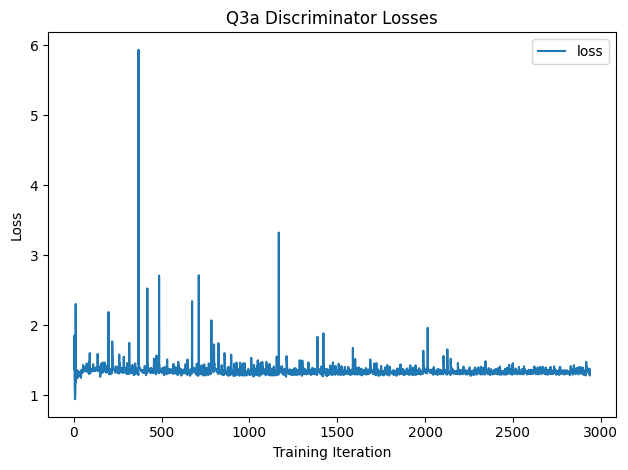

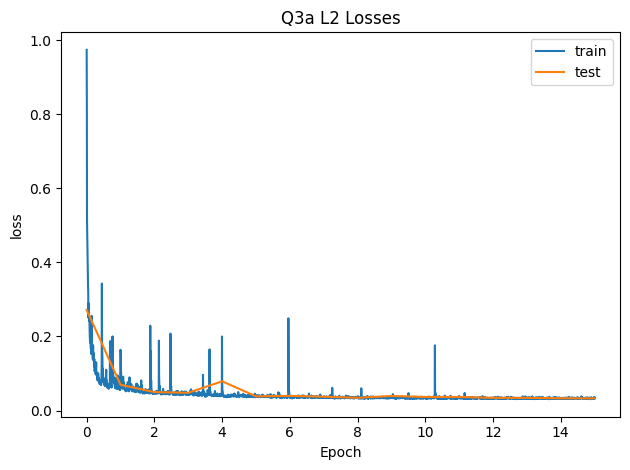

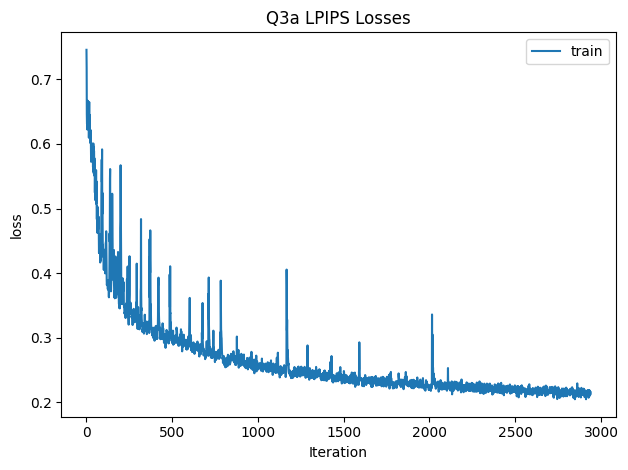

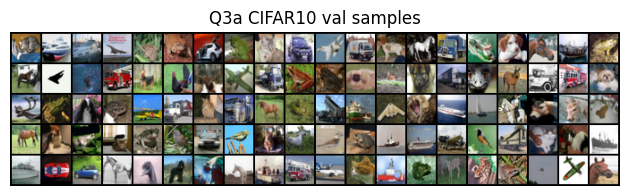

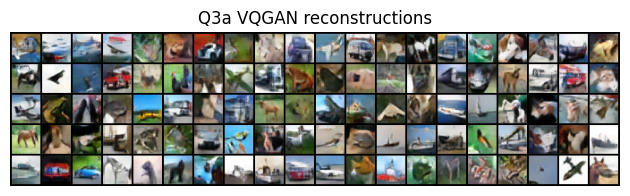

final_val_reconstruction_loss: 0.03288711574673653


In [31]:
q3_save_results(q3a, "a") # with pips

## Part b: VIT-VQGAN [15]
In this part, you will replace the encoder and decoder in the VQGAN with a Vision Transformer (ViT) following the [Improved VQGAN paper](https://arxiv.org/abs/2110.04627). You may use pre-built ViT modules and/or transformers libraries for the purposes of this exercise. Split images into 4x4 patches which should give you 8x8 patches for each image.

**Discriminator**
In ViT-VQGAN, the patch-based discriminator is replaced with a full StyleGAN discriminator. For the purposes of this exercise, you should use the same discrimiator as described in part a but without splitting into patches. In addition add [spectral normalization](https://pytorch.org/docs/stable/generated/torch.nn.utils.spectral_norm.html#torch-nn-utils-spectral-norm) to all the conv and linear layers and use LeakyReLU instead of ReLU, following [SN-GANs](https://arxiv.org/abs/1802.05957). This is to help with training stability.
```
def Discriminator(*, n_filters=128):
    # all conv layers in the ResBlocks should have spectral normalization
    ResnetBlockDown(3, n_filters=n_filters),
    ResnetBlockDown(128, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    ResBlock(n_filters, n_filters=n_filters),
    nn.LeakyReLU()
    global sum pooling
    nn.Linear(128, 1)
```
* in addition add 

**Loss function**
$L = L_{VQ} + 0.1 L_{GAN} + \alpha L_{perceptual} + L_2 + 0.1 L_1$

The ViT-VQGAN paper introduces a new loss term $L_{Logit\_laplace}$ which is a logit laplace loss. For simplicity, we will use an L1 loss instead.

If you implemented the perceptual loss in the previous part, you can use the same perceptual loss here, otherwise you may keep $\alpha = 0$.


You should be able to largely be able to reuse your implementations in the previous part for this problem
The only 3 updates you need are:
* use ViT for encoder and decoder of VQVAE, use 4 layers, 8 heads, and 256 for the embedding size 
* add L1 loss
* change the discrimiator to look at the full image

**You will provide the following deliverables**
1. Final L2 reconstruction loss
2. Discriminator loss across training
3. $L_{perceptual}$ loss across training
4. Training l2 loss across training
5. Validation l2 reconstruction loss across training, evaluated at the end of every epoch
6. 100 reconstructions of the validation set.


In [30]:
import math
from dataclasses import dataclass

import torch
import torch.nn as nn
from torch.nn import functional as F


@dataclass
class TransformerConfig:
    block_size: int = 64
    model_type: str = "gpt"
    n_layer: int = 2
    n_head: int = 4
    n_embd: int = 128
    embd_pdrop: float = 0.0
    resid_pdrop: float = 0.0
    attn_pdrop: float = 0.0
    use_start_of_sequence_token: bool = False


class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    It is possible to use torch.nn.MultiheadAttention here but I am including an
    explicit implementation here to show that there is nothing too scary here.
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer(
            "bias",
            torch.tril(torch.ones(config.block_size, config.block_size)).view(
                1, 1, config.block_size, config.block_size
            ),
        )
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        (
            B,
            T,
            C,
        ) = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(
            1, 2
        )  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:, :, :T, :T] == 0, float("-inf"))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = (
            y.transpose(1, 2).contiguous().view(B, T, C)
        )  # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y


class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(
            dict(
                c_fc=nn.Linear(config.n_embd, 4 * config.n_embd),
                c_proj=nn.Linear(4 * config.n_embd, config.n_embd),
                act=nn.GELU(),
                dropout=nn.Dropout(config.resid_pdrop),
            )
        )
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x))))  # MLP forward

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlpf(self.ln_2(x))
        return x


class Transformer(nn.Module):
    """
    Transformer that operates on embedding (no token conversion)
    """

    def __init__(self, config: TransformerConfig):
        super().__init__()
        assert config.block_size is not None
        self.block_size = config.block_size
        self.transformer = nn.ModuleDict(
            dict(
                wpe=nn.Embedding(config.block_size, config.n_embd),
                drop=nn.Dropout(config.embd_pdrop),
                h=nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
                ln_f=nn.LayerNorm(config.n_embd),
            )
        )
        # self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)
        if config.use_start_of_sequence_token:
            self.start_of_sequence_token = nn.Parameter(torch.randn(1, 1, config.n_embd))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.transformer.parameters())
        print("number of parameters: %.2fM" % (n_params / 1e6,))

    def forward(self, embed):
        device = embed.device
        b, t, n_embd = embed.size()
        assert (
            t <= self.block_size
        ), f"Cannot forward sequence of length {t}, block size is only {self.block_size}"

        if t != 0:
            pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(
                0
            )  # shape (1, t)

            # forward the GPT model itself
            pos_emb = self.transformer.wpe(
                pos
            )  # position embeddings of shape (1, t, n_embd)
            x = self.transformer.drop(embed + pos_emb)
        else:
            x = None

        # append start of sequence token if applicable to the start
        if hasattr(self, "start_of_sequence_token"):
            sos_emb = self.start_of_sequence_token.expand(b, 1, -1)
            if x is None:
                x = sos_emb
            else:
                x = torch.cat((sos_emb, x), dim=1)

            if x.shape[1] > self.block_size:
                x = x [:, :self.block_size, :]

        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        # logits = self.lm_head(x)
        return x

In [55]:
class ViTEncoder(Transformer):
    """
    Use ViT as encoder for VQGAN
    Convert image to patches to feed into transformer
    """
    def __init__(self, config):
        super().__init__(config)
        self.n_embd = config.n_embd
        self.patch_size = 4
        self.conv_proj = nn.Conv2d(in_channels=3, out_channels=self.n_embd, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        """
        Args:
            x: input image, [B, 3, 32, 32]
        Returns:
            x: embedding, [B, 64, n_embd]
        """
        B = x.size(0)
        # [B, n_embd, 8, 8]
        x = self.conv_proj(x)
        # [B, 64, n_embd]
        x = x.view(B, self.n_embd, -1).permute(0, 2, 1)
        return super().forward(x)


class ViTDecoder(Transformer):
    """
    Use ViT as decoder for VQGAN
    Convert sequence of token embeddings back to image
    """
    def __init__(self, config):
        super().__init__(config)
        self.n_embd = config.n_embd
        self.patch_size = 4
        self.image_size = 32
        self.conv_transpose = nn.ConvTranspose2d(in_channels=self.n_embd, out_channels=3, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        """
        Args:
            x: embedding, [B, 64, n_embd]
        Returns:
            x: output image, [B, 3, 32, 32]
        """
        B = x.size(0)
        # [B, 64, n_embd]
        x = super().forward(x)
        # [B, n_embd, 8, 8]
        n_patches = self.image_size // self.patch_size
        x = x.permute(0, 2, 1).view(B, -1, n_patches, n_patches)
        # [B, 3, 32, 32]
        x = self.conv_transpose(x)
        return x


class ViTQuantize(Quantize):
    """
    Quantize latents of shape [B, L, D] instead of [B, C, H, W]
    """
    def __init__(self, size, code_dim):
        super().__init__(size, code_dim)

    def forward(self, z):
        B, L, D = z.shape
        assert (D == self.code_dim)
        weight = self.embedding.weight

        # [B*L, D]
        flat_inputs = z.view(-1, self.code_dim)
        # [B*L, D] vs. [D, K] --> [B*L, K]
        distances = (flat_inputs ** 2).sum(dim=1, keepdim=True) \
                    - 2 * torch.mm(flat_inputs, weight.t()) \
                    + (weight.t() ** 2).sum(dim=0, keepdim=True)
        # [B*L, 1]
        encoding_indices = torch.max(-distances, dim=1)[1]
        encoding_indices = encoding_indices.view(B, L)
        # [B, L, D]
        quantized = self.embedding(encoding_indices)

        return quantized, (quantized - z).detach() + z, encoding_indices

In [61]:
class ViTVQGANCritic(VQGANCritic):
    def __init__(self, n_filters=128):
        super().__init__(n_filters)
        self.resnet_block_down1 = ResnetBlockDown(in_dim=3, n_filters=n_filters, use_spectral_norm=True)
        self.resnet_block_down2 = ResnetBlockDown(in_dim=128, n_filters=n_filters, use_spectral_norm=True)
        self.res_block1 = ResBlock(in_dim=n_filters, n_filters=n_filters, use_spectral_norm=True)
        self.res_block2 = ResBlock(in_dim=n_filters, n_filters=n_filters, use_spectral_norm=True)
        self.relu = nn.LeakyReLU()
        # Assuming global sum pooling is done manually in the forward method
        self.linear = nn.Linear(n_filters, 1)

    def forward(self, x):    
        x = self.resnet_block_down1(x) # [B * 16, 3, 4, 4]
        x = self.resnet_block_down2(x) # [B * 16, 3, 2, 2]
        x = self.res_block1(x)
        x = self.res_block2(x) 
        x = self.relu(x)
        # Implementing global sum pooling as a sum followed by a reshape
        x = torch.sum(x, dim=[2, 3])  # Assuming x has shape [batch_size, n_filters, height, width]
        x = self.linear(x)
        return x


class ViTVQGANGenerator(VQGANGenerator):
    def __init__(self, code_dim, code_size, vit_config):
        super().__init__(code_dim, code_size)
        # encoder and decoder replaced with ViT
        self.encoder = ViTEncoder(vit_config)
        self.decoder = ViTDecoder(vit_config)
        # use ViT quantize function
        self.codebook = ViTQuantize(code_size, code_dim)

    def decode_code(self, latents):
        with torch.no_grad():
            # [B, 64, n_embd]
            latents = self.codebook.embedding(latents)
            # [B, 32, 32, 3]
            return self.decoder(latents).permute(0, 2, 3, 1).cpu().numpy() * 0.5 + 0.5
    
    def loss(self, x, critic):
        out = self(x)
        x_tilde = out['x_fake']
        vq_loss = out['vq_loss']
        recon_loss = F.mse_loss(x_tilde, x)
        # non-saturating generator gan loss
        d_x_fake = critic(x_tilde)
        gan_loss = F.binary_cross_entropy_with_logits(d_x_fake, torch.full_like(d_x_fake, 1).cuda())
        percep_loss = self.lpips_loss(x, x_tilde).mean()
        # add l1 loss on reconstruction
        l1_loss = F.l1_loss(x_tilde, x)
        loss = recon_loss + vq_loss + 0.1 * gan_loss + 0.5 * percep_loss + 0.1 * l1_loss
        return OrderedDict(loss=loss, recon_loss=recon_loss, reg_loss=vq_loss, gan_loss=gan_loss, percep_loss=percep_loss, l1_loss=l1_loss)

In [80]:
def q3b(train_data, val_data, reconstruct_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    val_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]
    reconstruct_data: An (100, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]. To be used for reconstruction

    Returns
    - a (# of training iterations,) numpy array of the discriminator train losses evaluated every minibatch
    - None or a (# of training iterations,) numpy array of the perceptual train losses evaluated every minibatch
    - a (# of training iterations,) numpy array of the l2 reconstruction evaluated every minibatch
    - a (# of epochs + 1,) numpy array of l2 reconstruction loss evaluated once at initialization and after each epoch on the val_data
    - a (100, 32, 32, 3) numpy array of reconstructions from your model in [0, 1] on the reconstruct_data.  
    """

    code_dim, code_size = 256, 1024
    vit_config = TransformerConfig(n_embd=code_dim, n_layer=4, n_head=8)
    critic = ViTVQGANCritic().cuda()
    generator = ViTVQGANGenerator(code_dim, code_size, vit_config).cuda()
    # map to [-1, 1]
    train_data = 2 * train_data - 1
    val_data = 2 * val_data - 1
    train_loader = data.DataLoader(torch.tensor(train_data).to(torch.float32), batch_size=256, shuffle=True)
    val_loader = data.DataLoader(torch.tensor(val_data).to(torch.float32), batch_size=256)
    train_args = dict(epochs=30, lr=1e-3, adam_betas=(0.5, 0.9), n_critic_steps=1)

    discriminator_losses, generator_losses, val_losses = train_epochs(
        critic, generator, train_loader, train_args, val_loader=val_loader)
    l_pips_losses = generator_losses['percep_loss']
    l2_recon_train = generator_losses['recon_loss']
    l2_recon_test = val_losses['recon_loss']

    with torch.no_grad():
        x = torch.tensor(reconstruct_data).to(torch.float32).cuda()
        z = generator.encode_code(x)
        reconstructions = generator.decode_code(z)
    
    return discriminator_losses, l_pips_losses, l2_recon_train, l2_recon_test, reconstructions

Files already downloaded and verified
Files already downloaded and verified
loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips/vgg.pth
number of parameters: 3.18M
number of parameters: 3.18M


100%|██████████| 30/30 [16:16<00:00, 32.55s/it]


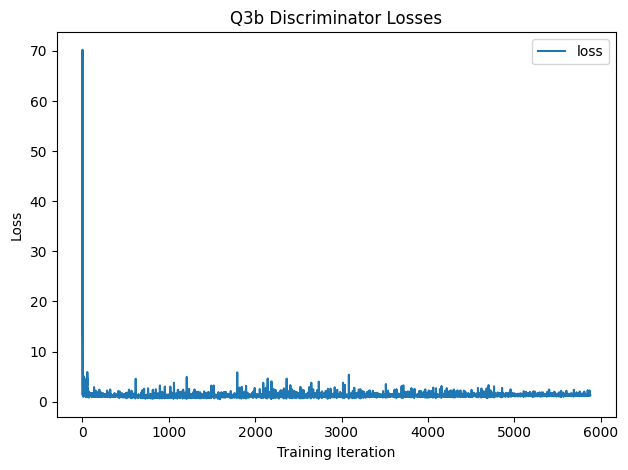

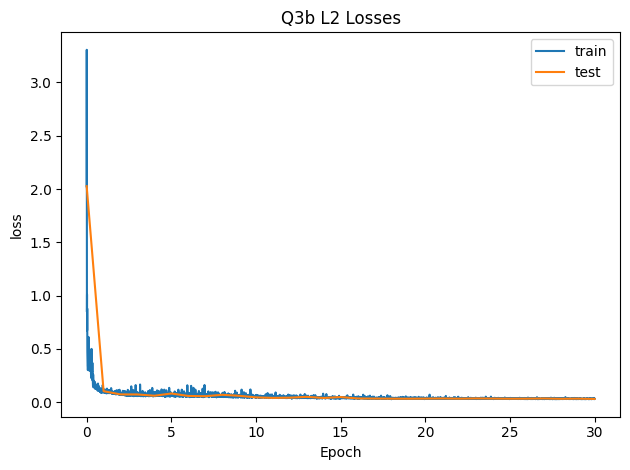

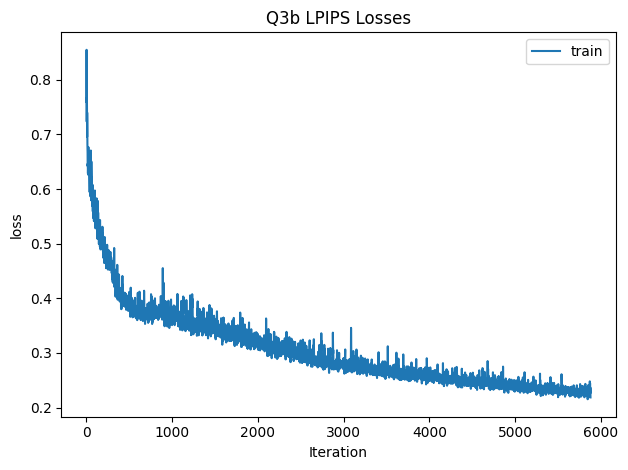

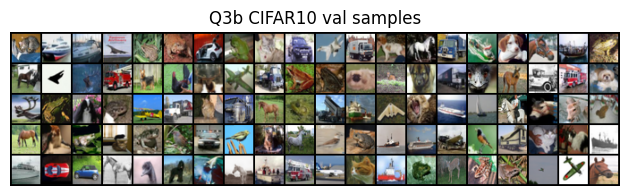

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


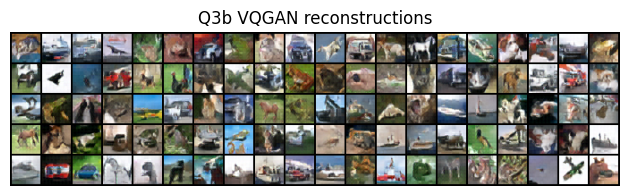

final_val_reconstruction_loss: 0.03173359628915787


In [81]:
q3_save_results(q3b, "b")

# Question 4 (Bonus): CycleGAN [20pt]
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def q4(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

In [ ]:
q4_save_results(q4)